In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.6 MB/s eta 0:00:00


In [ ]:
import os
import time
import random
import numpy as np
import pandas as pd
import sentencepiece as spm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from jiwer import wer, cer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
import re
import math

In [ ]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
# Check if GPU is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


In [ ]:
# Create output directory
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = '/content/drive/MyDrive/output_transformer_subword/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

Mounted at /content/drive


In [ ]:
# # Create output directory
# OUTPUT_DIR = './output_transformer_subword/'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

In [ ]:
# Paths for saving/loading
DATASET_PATH = './exportStatements.xlsx'
TOKENIZER_MODEL_PATH = os.path.join(OUTPUT_DIR, 'sentencepiece.model')
TOKENIZER_VOCAB_PATH = os.path.join(OUTPUT_DIR, 'sentencepiece.vocab')
PREPROCESSED_DATA_PATH = os.path.join(OUTPUT_DIR, 'preprocessed_data.pkl')
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_transformer_model_subword.pt')
BEST_CER_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_transformer_model_cer.pt')
LOSS_PLOT_PATH = os.path.join(OUTPUT_DIR, 'transformer_loss_plot_subword.png')
ER_PLOT_PATH = os.path.join(OUTPUT_DIR, 'er_plot_subword.png')

In [ ]:
# Load the dataset
df = pd.read_excel(DATASET_PATH)

In [ ]:
# Check for missing values in 'inFormalForm' and 'FormalForm'
print("Missing values in 'inFormalForm':", df['inFormalForm'].isnull().sum())
print("Missing values in 'FormalForm':", df['FormalForm'].isnull().sum())

# Drop rows with missing values in 'inFormalForm' and 'FormalForm'
initial_length = len(df)
df = df.dropna(subset=['inFormalForm', 'FormalForm']).reset_index(drop=True)
final_length = len(df)

df['inFormalForm'] = df['inFormalForm'].astype(str)
df['FormalForm'] = df['FormalForm'].astype(str)

print(f"Dropped {initial_length - final_length} rows due to missing values.")

Missing values in 'inFormalForm': 0
Missing values in 'FormalForm': 1
Dropped 1 rows due to missing values.


In [ ]:
def clean_persian_text(text):
    # 1. Keep only Persian letters, English letters, digits, whitespace, ZWNJ
    text = re.sub(r"[^\u0600-\u06FFa-zA-Z0-9\u06F0-\u06F9\u0660-\u0669\u200c\s]", " ", text)
    # Remove leftover Persian punctuations explicitly (، ؛ ؟)
    text = re.sub(r"[،؛؟]", " ", text)
    # Remove Arabic diacritics (harakat)
    arabic_diacritics = r"[\u064B-\u065F\u0670\u06D6-\u06ED]"
    text = re.sub(arabic_diacritics, "", text)

    # 2. Normalize Persian/Arabic digits to Western digits
    persian_digits = "۰۱۲۳۴۵۶۷۸۹"
    arabic_digits = "٠١٢٣٤٥٦٧٨٩"
    for p, a, e in zip(persian_digits, arabic_digits, "0123456789"):
        text = text.replace(p, e).replace(a, e)

    # 3. Separate numbers stuck to Persian/English letters
    text = re.sub(r"(\d+)(?=[\u0600-\u06FFa-zA-Z])", r"\1 ", text)  # digit before letter
    text = re.sub(r"([\u0600-\u06FFa-zA-Z])(?=\d+)", r"\1 ", text)  # letter before digit

    # 4. Remove underscores
    text = re.sub(r"_+", "", text)

    # 5. Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
df['inFormalForm'] = df['inFormalForm'].apply(clean_persian_text)
df['FormalForm'] = df['FormalForm'].apply(clean_persian_text)

In [ ]:
# Split data into training, validation, and test sets (80%, 10%, 10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

In [ ]:
# Check if tokenizer model exists
if not os.path.exists(TOKENIZER_MODEL_PATH):
    print('Training SentencePiece tokenizer...')
    # Save combined sentences for tokenizer training
    all_sentences_path = os.path.join(OUTPUT_DIR, 'all_sentences.txt')
    with open(all_sentences_path, 'w', encoding='utf-8') as f:
        for sent in pd.concat([train_df['inFormalForm'], train_df['FormalForm']]):
            f.write(sent.strip() + '\n')

    # Adjusted vocab_size to 26000
    spm.SentencePieceTrainer.Train(
        input=all_sentences_path,
        model_prefix=os.path.join(OUTPUT_DIR, 'sentencepiece'),
        vocab_size=26000,
        model_type='unigram',
        character_coverage=1.0,
        pad_id=0,      # ID for <pad>
        unk_id=1,      # ID for <unk> (reserved, do not redefine)
        bos_id=2,      # ID for <s> (reserved)
        eos_id=3,      # ID for </s> (reserved)
        user_defined_symbols=['<pad>']  # Only include <pad> as user-defined symbol
    )
    print('Tokenizer trained and saved.')
else:
    print('Loading existing tokenizer.')

Training SentencePiece tokenizer...
Tokenizer trained and saved.


In [ ]:
# Load the trained tokenizer
sp = spm.SentencePieceProcessor()
sp.Load(TOKENIZER_MODEL_PATH)
print(f'Vocabulary size: {sp.get_piece_size()}')

# Special token IDs
PAD_IDX = sp.piece_to_id('<pad>')   # Should be 0
UNK_IDX = sp.piece_to_id('<unk>')   # Should be 1
BOS_IDX = sp.piece_to_id('<s>')     # Should be 2
EOS_IDX = sp.piece_to_id('</s>')    # Should be 3

PAD_IDX, UNK_IDX, BOS_IDX, EOS_IDX

Vocabulary size: 26000


(0, 1, 2, 3)

In [ ]:
# Maximum sequence length (based on dataset)
def get_max_len(df_list):
    max_len = 0
    for df in df_list:
        lengths_src = df['inFormalForm'].apply(lambda x: len(sp.EncodeAsIds(x)) + 2)  # +2 for BOS and EOS
        lengths_trg = df['FormalForm'].apply(lambda x: len(sp.EncodeAsIds(x)) + 2)
        max_len = max(max_len, lengths_src.max(), lengths_trg.max())
    return max_len

MAX_LEN = get_max_len([train_df, val_df, test_df])

MAX_LEN

96

In [ ]:
# Check if preprocessed data exists
if not os.path.exists(PREPROCESSED_DATA_PATH):
    print('Preprocessing data...')
    # Preprocess and tokenize all sentences
    def preprocess_data(df, sp, max_len=MAX_LEN):
        src_texts = df['inFormalForm'].tolist()
        trg_texts = df['FormalForm'].tolist()
        src_sequences = []
        trg_sequences = []
        for src, trg in zip(src_texts, trg_texts):
            src_ids = [BOS_IDX] + sp.EncodeAsIds(src) + [EOS_IDX]
            trg_ids = [BOS_IDX] + sp.EncodeAsIds(trg) + [EOS_IDX]
            # Pad or truncate sequences
            src_ids = src_ids[:max_len] + [PAD_IDX] * max(0, max_len - len(src_ids))
            trg_ids = trg_ids[:max_len] + [PAD_IDX] * max(0, max_len - len(trg_ids))
            src_sequences.append(src_ids)
            trg_sequences.append(trg_ids)
        return src_sequences, trg_sequences

    # Tokenize and preprocess data
    train_src, train_trg = preprocess_data(train_df, sp)
    val_src, val_trg = preprocess_data(val_df, sp)
    test_src, test_trg = preprocess_data(test_df, sp)

    # Save preprocessed data
    with open(PREPROCESSED_DATA_PATH, 'wb') as f:
        pickle.dump({
            'train_src': train_src,
            'train_trg': train_trg,
            'val_src': val_src,
            'val_trg': val_trg,
            'test_src': test_src,
            'test_trg': test_trg,
            'MAX_LEN': MAX_LEN
        }, f)
    print('Preprocessed data saved.')
else:
    print('Loading preprocessed data...')
    # Load preprocessed data
    with open(PREPROCESSED_DATA_PATH, 'rb') as f:
        data = pickle.load(f)
        train_src = data['train_src']
        train_trg = data['train_trg']
        val_src = data['val_src']
        val_trg = data['val_trg']
        test_src = data['test_src']
        test_trg = data['test_trg']
        MAX_LEN = data['MAX_LEN']

Preprocessing data...
Preprocessed data saved.


In [ ]:
# Prepare datasets
class TranslationDataset(Dataset):
    def __init__(self, src_sequences, trg_sequences):
        self.src_sequences = src_sequences
        self.trg_sequences = trg_sequences

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        src_ids = torch.tensor(self.src_sequences[idx], dtype=torch.long)
        trg_ids = torch.tensor(self.trg_sequences[idx], dtype=torch.long)
        return src_ids, trg_ids

In [ ]:
# Collate function to create masks and pad sequences
def collate_fn(batch, pad_idx):
    src_batch, trg_batch = zip(*batch)
    src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=pad_idx, batch_first=True)
    trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, padding_value=pad_idx, batch_first=True)
    return src_batch, trg_batch

In [ ]:
# Create datasets and dataloaders
batch_size = 32

train_dataset = TranslationDataset(train_src, train_trg)
val_dataset = TranslationDataset(val_src, val_trg)
test_dataset = TranslationDataset(test_src, test_trg)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, PAD_IDX))
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=lambda x: collate_fn(x, PAD_IDX))
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=lambda x: collate_fn(x, PAD_IDX))

In [ ]:
# Function to generate subsequent masks for target
def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones((sz, sz), device=DEVICE), diagonal=1).bool()
    return mask.float().masked_fill(mask, float('-inf'))

In [ ]:
# Function to create padding masks
def create_mask(src, tgt, pad_idx):
    src_seq_len = src.size(1)
    tgt_seq_len = tgt.size(1)

    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).float()
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    src_padding_mask = (src == pad_idx)
    tgt_padding_mask = (tgt == pad_idx)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
# Transformer Model Definition
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size,
                 nhead, src_vocab_size, tgt_vocab_size, dim_feedforward=512,
                 dropout=0.1, max_len=MAX_LEN, pad_idx=PAD_IDX):
        super(Seq2SeqTransformer, self).__init__()
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.emb_size = emb_size
        self.pad_idx = pad_idx
        self.max_len = max_len

        # Token embedding layers
        self.src_embedding = nn.Embedding(src_vocab_size, emb_size, padding_idx=pad_idx)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, emb_size, padding_idx=pad_idx)

        # Learned positional embeddings
        self.src_pos_embedding = nn.Embedding(max_len, emb_size)
        self.tgt_pos_embedding = nn.Embedding(max_len, emb_size)

        # Transformer
        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)

        # Output layer
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        # src and tgt shape: [batch_size, seq_len]
        src_seq_len = src.size(1)
        tgt_seq_len = tgt.size(1)
        src_positions = torch.arange(0, src_seq_len, device=src.device).unsqueeze(0).expand(src.size(0), -1)
        tgt_positions = torch.arange(0, tgt_seq_len, device=tgt.device).unsqueeze(0).expand(tgt.size(0), -1)

        # Embed and encode source
        src_tok = self.src_embedding(src) * math.sqrt(self.emb_size)
        src_emb = src_tok + self.src_pos_embedding(src_positions)
        
        # Embed and encode target
        tgt_tok = self.tgt_embedding(tgt) * math.sqrt(self.emb_size)
        tgt_emb = tgt_tok + self.tgt_pos_embedding(tgt_positions)

        # Transformer
        output = self.transformer(
            src_emb.transpose(0, 1), tgt_emb.transpose(0, 1),
            src_mask=src_mask, tgt_mask=tgt_mask, memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

        output = output.transpose(0,1)
        logits = self.generator(output)
        return logits

    def encode(self, src, src_mask, src_key_padding_mask=None):
        src_seq_len = src.size(1)
        src_positions = torch.arange(0, src_seq_len, device=src.device).unsqueeze(0).expand(src.size(0), -1)
        src_tok = self.src_embedding(src) * math.sqrt(self.emb_size)
        src_emb = src_tok + self.src_pos_embedding(src_positions)
        return self.transformer.encoder(
            src_emb.transpose(0, 1),
            mask=src_mask,
            src_key_padding_mask=src_key_padding_mask
        )

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt_seq_len = tgt.size(1)
        tgt_positions = torch.arange(0, tgt_seq_len, device=tgt.device).unsqueeze(0).expand(tgt.size(0), -1)
        tgt_tok = self.tgt_embedding(tgt) * math.sqrt(self.emb_size)
        tgt_emb = tgt_tok + self.tgt_pos_embedding(tgt_positions)
        return self.transformer.decoder(
            tgt_emb.transpose(0, 1), memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

In [ ]:
# Initialize model parameters
VOCAB_SIZE = sp.get_piece_size()
SRC_VOCAB_SIZE = VOCAB_SIZE
TGT_VOCAB_SIZE = VOCAB_SIZE

# Hyperparameters
num_encoder_layers = 3
num_decoder_layers = 3
emb_size = 256
nhead = 8
dim_feedforward = 256
dropout = 0.1


model = Seq2SeqTransformer(num_encoder_layers, num_decoder_layers, emb_size,
                           nhead, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                           dim_feedforward, dropout, MAX_LEN, PAD_IDX).to(DEVICE)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
def evaluate_wer(model, dataloader, sp, max_batches=None):
    model.eval()
    cer_scores = []
    wer_scores = []
    batches_processed = 0

    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)
            device = src.device

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg[:, :-1], PAD_IDX)

            # encode
            memory = model.encode(src, src_mask, src_key_padding_mask=src_padding_mask)

            # start with BOS
            ys = torch.full((src.size(0), 1), BOS_IDX, dtype=torch.long, device=device)

            for _ in range(MAX_LEN - 1):
                tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(device)
                out = model.decode(
                    ys, memory, tgt_mask,
                    tgt_key_padding_mask=None,
                    memory_key_padding_mask=src_padding_mask
                )  # shape: (tgt_len, batch, emb)
                out = out.transpose(0, 1)                       # (batch, tgt_len, emb)
                logits = model.generator(out[:, -1, :])         # (batch, vocab)
                next_token = logits.argmax(dim=-1, keepdim=True)  # (batch, 1)
                ys = torch.cat([ys, next_token], dim=1)
                if (next_token.squeeze(1) == EOS_IDX).all():
                    break

            preds = ys

            # strip BOS for text
            pred_ids = preds[:, 1:].tolist()
            trg_out = trg[:, 1:].tolist()  # Remove first token (<s>) for target

            for pred_ids, trg_ids in zip(pred_ids, trg_out):
                # Remove PAD and special tokens
                pred_ids = [idx for idx in pred_ids if idx not in [PAD_IDX, EOS_IDX, BOS_IDX]]
                trg_ids = [idx for idx in trg_ids if idx not in [PAD_IDX, EOS_IDX, BOS_IDX]]

                pred_sentence = sp.DecodeIds(pred_ids)
                trg_sentence = sp.DecodeIds(trg_ids)

                cer_score = cer(trg_sentence, pred_sentence)
                wer_score = wer(trg_sentence, pred_sentence)

                cer_scores.append(cer_score)
                wer_scores.append(wer_score)

            batches_processed += 1
            if max_batches and batches_processed >= max_batches:
                break

    avg_cer = float(np.mean(cer_scores))
    avg_wer = float(np.mean(wer_scores))
    return avg_cer, avg_wer

In [ ]:
# Training loop
N_EPOCHS = 100
best_valid_loss = float('inf')
best_valid_cer = float('inf')
patience = 5
counter = 0

train_losses = []
valid_losses = []

train_wers = []
valid_wers = []
train_cers = []
valid_cers = []

for epoch in range(1, N_EPOCHS + 1):
    start_time = time.time()

    # Training
    model.train()
    epoch_train_loss = 0
    for src, trg in tqdm(train_loader, desc=f'Training Epoch {epoch}/{N_EPOCHS}'):
        src = src.to(DEVICE)
        trg = trg.to(DEVICE)

        # Create masks
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg[:, :-1], PAD_IDX)

        optimizer.zero_grad()
        output = model(src, trg[:, :-1], src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        trg_out = trg[:, 1:]

        output = output.reshape(-1, TGT_VOCAB_SIZE)
        trg_out = trg_out.reshape(-1)

        loss = criterion(output, trg_out)
        loss.backward()

        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)


    # Validation
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(val_loader, desc=f'Validation Epoch {epoch}/{N_EPOCHS}'):
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg[:, :-1], PAD_IDX)

            output = model(src, trg[:, :-1], src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

            trg_out = trg[:, 1:]

            output = output.reshape(-1, TGT_VOCAB_SIZE)
            trg_out = trg_out.reshape(-1)

            loss = criterion(output, trg_out)
            epoch_valid_loss += loss.item()

    epoch_valid_loss /= len(val_loader)
    valid_losses.append(epoch_valid_loss)

    # Evaluate WER
    valid_cer, valid_wer = evaluate_wer(model, val_loader, sp)
    valid_wers.append(valid_wer)
    valid_cers.append(valid_cer)

    print(f'\tTrain Loss: {epoch_train_loss:.3f}')
    print(f'\tValid Loss: {epoch_valid_loss:.3f}')
    print(f'\tValid WER: {valid_wer:.4f}')
    print(f'\tValid CER: {valid_cer:.4f}')

    # Early stopping check
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f'Validation loss improved. Model saved to {BEST_MODEL_PATH}.')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Early stopping triggered.')
            break

    if valid_cer < best_valid_cer:
        best_valid_cer = valid_cer
        torch.save(model.state_dict(), BEST_CER_MODEL_PATH)
        print(f'Validation CER improved. Model saved to {BEST_CER_MODEL_PATH}.')

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)

    print(f'Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s')

Training Epoch 1/100:   0%|          | 0/1251 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Validation Epoch 1/100: 100%|██████████| 157/157 [00:04<00:00, 32.86it/s]


	Train Loss: 4.492
	Valid Loss: 4.152
	Valid WER: 1.5641
	Valid CER: 1.2191
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_cer.pt.
Epoch: 01 | Time: 3m 13s


Validation Epoch 2/100: 100%|██████████| 157/157 [00:04<00:00, 31.64it/s]


	Train Loss: 3.769
	Valid Loss: 3.629
	Valid WER: 1.2265
	Valid CER: 0.9679
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_cer.pt.
Epoch: 02 | Time: 3m 5s


Validation Epoch 3/100: 100%|██████████| 157/157 [00:04<00:00, 32.82it/s]


	Train Loss: 3.155
	Valid Loss: 3.206
	Valid WER: 0.9680
	Valid CER: 0.7713
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_cer.pt.
Epoch: 03 | Time: 2m 42s


Validation Epoch 4/100: 100%|██████████| 157/157 [00:04<00:00, 32.27it/s]


	Train Loss: 2.639
	Valid Loss: 2.891
	Valid WER: 1.1002
	Valid CER: 0.8981
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 04 | Time: 2m 49s


Validation Epoch 5/100: 100%|██████████| 157/157 [00:04<00:00, 32.15it/s]


	Train Loss: 2.226
	Valid Loss: 2.645
	Valid WER: 1.3169
	Valid CER: 1.1067
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 05 | Time: 3m 4s


Validation Epoch 6/100: 100%|██████████| 157/157 [00:04<00:00, 32.43it/s]


	Train Loss: 1.897
	Valid Loss: 2.512
	Valid WER: 1.0265
	Valid CER: 0.8374
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 06 | Time: 2m 50s


Validation Epoch 7/100: 100%|██████████| 157/157 [00:04<00:00, 32.34it/s]


	Train Loss: 1.641
	Valid Loss: 2.382
	Valid WER: 1.3075
	Valid CER: 1.1226
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 07 | Time: 2m 58s


Validation Epoch 8/100: 100%|██████████| 157/157 [00:04<00:00, 32.30it/s]


	Train Loss: 1.447
	Valid Loss: 2.331
	Valid WER: 0.8671
	Valid CER: 0.7040
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_cer.pt.
Epoch: 08 | Time: 2m 38s


Validation Epoch 9/100: 100%|██████████| 157/157 [00:04<00:00, 32.19it/s]


	Train Loss: 1.287
	Valid Loss: 2.242
	Valid WER: 0.9387
	Valid CER: 0.7780
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 09 | Time: 2m 46s


Validation Epoch 10/100: 100%|██████████| 157/157 [00:04<00:00, 32.51it/s]


	Train Loss: 1.161
	Valid Loss: 2.169
	Valid WER: 1.0124
	Valid CER: 0.8746
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 10 | Time: 2m 49s


Validation Epoch 11/100: 100%|██████████| 157/157 [00:04<00:00, 32.41it/s]


	Train Loss: 1.053
	Valid Loss: 2.141
	Valid WER: 1.3112
	Valid CER: 1.1382
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 11 | Time: 3m 4s


Validation Epoch 12/100: 100%|██████████| 157/157 [00:04<00:00, 32.30it/s]


	Train Loss: 0.959
	Valid Loss: 2.140
	Valid WER: 1.0643
	Valid CER: 0.9050
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 12 | Time: 2m 47s


Validation Epoch 13/100: 100%|██████████| 157/157 [00:04<00:00, 32.65it/s]


	Train Loss: 0.883
	Valid Loss: 2.093
	Valid WER: 0.7394
	Valid CER: 0.6104
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_cer.pt.
Epoch: 13 | Time: 2m 38s


Validation Epoch 14/100: 100%|██████████| 157/157 [00:04<00:00, 32.34it/s]


	Train Loss: 0.812
	Valid Loss: 2.084
	Valid WER: 0.7179
	Valid CER: 0.5809
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_cer.pt.
Epoch: 14 | Time: 2m 40s


Validation Epoch 15/100: 100%|██████████| 157/157 [00:04<00:00, 32.36it/s]


	Train Loss: 0.754
	Valid Loss: 2.080
	Valid WER: 0.7161
	Valid CER: 0.5866
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 15 | Time: 2m 37s


Validation Epoch 16/100: 100%|██████████| 157/157 [00:04<00:00, 32.29it/s]


	Train Loss: 0.696
	Valid Loss: 2.051
	Valid WER: 0.7859
	Valid CER: 0.6450
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 16 | Time: 2m 35s


Validation Epoch 17/100: 100%|██████████| 157/157 [00:04<00:00, 32.24it/s]


	Train Loss: 0.650
	Valid Loss: 2.039
	Valid WER: 0.6740
	Valid CER: 0.5452
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_cer.pt.
Epoch: 17 | Time: 2m 35s


Validation Epoch 18/100: 100%|██████████| 157/157 [00:04<00:00, 32.40it/s]


	Train Loss: 0.608
	Valid Loss: 2.028
	Valid WER: 0.6115
	Valid CER: 0.4870
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_cer.pt.
Epoch: 18 | Time: 2m 34s


Validation Epoch 19/100: 100%|██████████| 157/157 [00:04<00:00, 32.64it/s]


	Train Loss: 0.571
	Valid Loss: 2.034
	Valid WER: 0.7560
	Valid CER: 0.6261
Epoch: 19 | Time: 2m 39s


Validation Epoch 20/100: 100%|██████████| 157/157 [00:04<00:00, 32.34it/s]


	Train Loss: 0.538
	Valid Loss: 2.047
	Valid WER: 0.7786
	Valid CER: 0.6389
Epoch: 20 | Time: 2m 40s


Validation Epoch 21/100: 100%|██████████| 157/157 [00:04<00:00, 32.68it/s]


	Train Loss: 0.507
	Valid Loss: 2.034
	Valid WER: 0.5790
	Valid CER: 0.4543
Validation CER improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_cer.pt.
Epoch: 21 | Time: 2m 32s


Validation Epoch 22/100: 100%|██████████| 157/157 [00:04<00:00, 32.42it/s]


	Train Loss: 0.477
	Valid Loss: 2.025
	Valid WER: 0.9379
	Valid CER: 0.8013
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 22 | Time: 2m 49s


Validation Epoch 23/100: 100%|██████████| 157/157 [00:04<00:00, 32.52it/s]


	Train Loss: 0.452
	Valid Loss: 2.035
	Valid WER: 0.7772
	Valid CER: 0.6486
Epoch: 23 | Time: 2m 37s


Validation Epoch 24/100: 100%|██████████| 157/157 [00:04<00:00, 32.36it/s]


	Train Loss: 0.429
	Valid Loss: 2.016
	Valid WER: 0.6127
	Valid CER: 0.4896
Validation loss improved. Model saved to /content/drive/MyDrive/output_transformer_subword/best_transformer_model_subword.pt.
Epoch: 24 | Time: 2m 40s


Validation Epoch 25/100: 100%|██████████| 157/157 [00:04<00:00, 32.35it/s]


	Train Loss: 0.407
	Valid Loss: 2.051
	Valid WER: 0.6440
	Valid CER: 0.5172
Epoch: 25 | Time: 2m 33s


Validation Epoch 26/100: 100%|██████████| 157/157 [00:04<00:00, 32.03it/s]


	Train Loss: 0.388
	Valid Loss: 2.017
	Valid WER: 0.6598
	Valid CER: 0.5344
Epoch: 26 | Time: 2m 32s


Validation Epoch 27/100: 100%|██████████| 157/157 [00:04<00:00, 32.88it/s]


	Train Loss: 0.368
	Valid Loss: 2.040
	Valid WER: 0.8700
	Valid CER: 0.7463
Epoch: 27 | Time: 2m 43s


Validation Epoch 28/100: 100%|██████████| 157/157 [00:04<00:00, 32.08it/s]


	Train Loss: 0.351
	Valid Loss: 2.056
	Valid WER: 0.6454
	Valid CER: 0.5227
Epoch: 28 | Time: 2m 34s


Validation Epoch 29/100: 100%|██████████| 157/157 [00:04<00:00, 32.23it/s]


	Train Loss: 0.340
	Valid Loss: 2.038
	Valid WER: 0.5382
	Valid CER: 0.4225
Early stopping triggered.


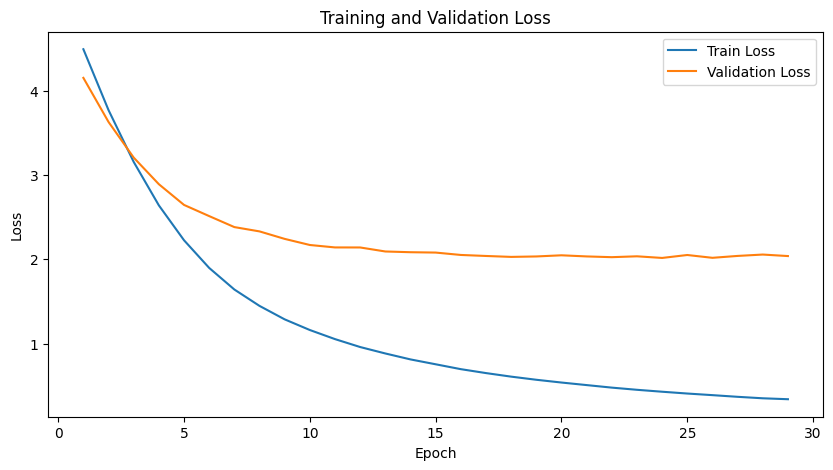

Loss plot saved to /content/drive/MyDrive/output_transformer_subword/transformer_loss_plot_subword.png.


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig(LOSS_PLOT_PATH)
plt.show()
print(f'Loss plot saved to {LOSS_PLOT_PATH}.')

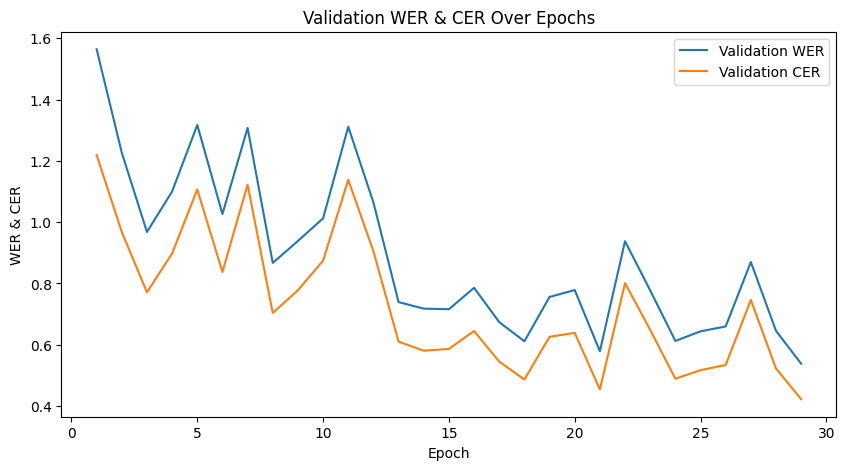

Plot saved to /content/drive/MyDrive/output_transformer_subword/er_plot_subword.png.


In [ ]:
# Plot validation CER & WER over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(valid_wers) + 1), valid_wers, label='Validation WER')
plt.plot(range(1, len(valid_cers) + 1), valid_cers, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('WER & CER')
plt.legend()
plt.title('Validation WER & CER Over Epochs')
plt.savefig(ER_PLOT_PATH)

plt.show()
print(f'Plot saved to {ER_PLOT_PATH}.')

In [ ]:
def greedy_decode_inference(model, src, src_mask, max_len, bos_idx):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    src_padding_mask = (src == PAD_IDX)

    memory = model.encode(src, src_mask, src_key_padding_mask=src_padding_mask)

    ys = torch.ones(1, 1).fill_(bos_idx).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask, tgt_key_padding_mask=None, memory_key_padding_mask=src_padding_mask)
        out = out.transpose(0,1)
        prob = model.generator(out[:, -1])
        next_word = torch.argmax(prob, dim=1).item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys

In [ ]:
def translate_sentence(sentence, model, sp, device, max_len=MAX_LEN, decoding_strategy='greedy'):
    model.eval()
    tokens = [BOS_IDX] + sp.EncodeAsIds(sentence) + [EOS_IDX]
    tokens = tokens[:max_len]
    src = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    src_mask = torch.zeros((src.shape[1], src.shape[1]), device=device).float()
    if decoding_strategy == 'greedy':
        tgt_tokens = greedy_decode_inference(model, src, src_mask, max_len, BOS_IDX).flatten()
    else:
        raise ValueError("Invalid decoding strategy")
    tgt_tokens = tgt_tokens.cpu().numpy()
    # Remove BOS token
    tgt_tokens = tgt_tokens[1:]
    # Stop at EOS token
    if EOS_IDX in tgt_tokens:
        eos_index = np.where(tgt_tokens == EOS_IDX)[0][0]
        tgt_tokens = tgt_tokens[:eos_index]
    translation = sp.DecodeIds(tgt_tokens.tolist())
    return translation

In [ ]:
def evaluate_and_save(model, df, src_sequences, trg_sequences, sp, file_name):
    model.eval()
    predictions = []
    cer_scores = []
    wer_scores = []

    for src_ids, trg_ids in tqdm(zip(src_sequences, trg_sequences), total=len(src_sequences), desc=f'Evaluating {file_name}'):
        src_sentence = sp.DecodeIds([id for id in src_ids if id not in [BOS_IDX, EOS_IDX, PAD_IDX]])
        trg_sentence = sp.DecodeIds([id for id in trg_ids if id not in [BOS_IDX, EOS_IDX, PAD_IDX]])

        pred_sentence = translate_sentence(src_sentence, model, sp, DEVICE)
        predictions.append(pred_sentence)
        cer_score = cer(trg_sentence, pred_sentence)
        wer_score = wer(trg_sentence, pred_sentence)
        cer_scores.append(cer_score)
        wer_scores.append(wer_score)

    results_df = pd.DataFrame({
        'Source': df['inFormalForm'],
        'Target': df['FormalForm'],
        'Prediction': predictions,
        'CER': cer_scores,
        'WER': wer_scores
    })

    results_df = results_df.sort_values(by=['CER', 'WER'], ascending=[True, True])

    results_path = os.path.join(OUTPUT_DIR, file_name)
    results_df.to_csv(results_path, index=False)
    avg_cer = np.mean(cer_scores)
    avg_wer = np.mean(wer_scores)
    print(f'Results saved to {results_path}')
    print(f'Average CER: {avg_cer:.4f}')
    print(f'Average WER: {avg_wer:.4f}')
    return results_df

In [ ]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))
print('Best model loaded.')

print('Evaluating on training data...')
train_results = evaluate_and_save(model, train_df, train_src, train_trg, sp, 'train_results_subword_transformer.csv')

print('Evaluating on validation data...')
val_results = evaluate_and_save(model, val_df, val_src, val_trg, sp, 'val_results_subword_transformer.csv')

print('Evaluating on test data...')
test_results = evaluate_and_save(model, test_df, test_src, test_trg, sp, 'test_results_subword_transformer.csv')

Best model loaded.
Evaluating on training data...


Evaluating train_results_subword_transformer.csv: 100%|██████████| 40008/40008 [51:01<00:00, 13.07it/s]


Results saved to /content/drive/MyDrive/output_transformer_subword/train_results_subword_transformer.csv
Average CER: 0.0874
Average WER: 0.1083
Evaluating on validation data...


Evaluating val_results_subword_transformer.csv: 100%|██████████| 5001/5001 [06:32<00:00, 12.73it/s]


Results saved to /content/drive/MyDrive/output_transformer_subword/val_results_subword_transformer.csv
Average CER: 0.3249
Average WER: 0.4280
Evaluating on test data...


Evaluating test_results_subword_transformer.csv: 100%|██████████| 5002/5002 [06:26<00:00, 12.93it/s]


Results saved to /content/drive/MyDrive/output_transformer_subword/test_results_subword_transformer.csv
Average CER: 0.3258
Average WER: 0.4324


In [ ]:
model.load_state_dict(torch.load(BEST_CER_MODEL_PATH))
print('Best CER model loaded.')

print('Evaluating on training data using best CER model...')
train_results = evaluate_and_save(model, train_df, train_src, train_trg, sp, 'train_results_subword_best_cer.csv')

print('Evaluating on validation data using best CER model...')
val_results = evaluate_and_save(model, val_df, val_src, val_trg, sp, 'val_results_subword_best_cer.csv')

print('Evaluating on test data using best CER model...')
test_results = evaluate_and_save(model, test_df, test_src, test_trg, sp, 'test_results_subword_best_cer.csv')

Best CER model loaded.
Evaluating on training data using best CER model...


Evaluating train_results_subword_best_cer.csv: 100%|██████████| 40008/40008 [49:18<00:00, 13.52it/s]


Results saved to /content/drive/MyDrive/output_transformer_subword/train_results_subword_best_cer.csv
Average CER: 0.1005
Average WER: 0.1257
Evaluating on validation data using best CER model...


Evaluating val_results_subword_best_cer.csv: 100%|██████████| 5001/5001 [06:17<00:00, 13.24it/s]


Results saved to /content/drive/MyDrive/output_transformer_subword/val_results_subword_best_cer.csv
Average CER: 0.3315
Average WER: 0.4381
Evaluating on test data using best CER model...


Evaluating test_results_subword_best_cer.csv: 100%|██████████| 5002/5002 [06:06<00:00, 13.65it/s]


Results saved to /content/drive/MyDrive/output_transformer_subword/test_results_subword_best_cer.csv
Average CER: 0.3304
Average WER: 0.4373
